In [15]:
# Imports

import math
import os
import random

import numpy as np
from matplotlib.axes import Axes
from numpy.typing import NDArray
from sklearn.decomposition import PCA
from tabulate import tabulate

from xrdpattern.pattern import PatternDB
from xrdpattern.pattern import XrdPattern
from matplotlib import pyplot as plt

from opxrd import OpXRD
from xrdpattern.xrd import LabelType

from holytools.devtools import Profiler
profiler = Profiler()

In [16]:
test_dirpath = '/home/daniel/aimat/data/opXRD/test'
full_dirpath = '/home/daniel/aimat/data/opXRD/final'
opxrd_databases = OpXRD.load_project_list(root_dirpath=test_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test
[2024-12-19 10:26:26]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/USC


100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-19 10:26:26]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/USC
[2024-12-19 10:26:26]: Successfully extracted 338 patterns from 338/338 xrd files
[2024-12-19 10:26:26]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/CNRS


100% (210 of 210) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-19 10:26:28]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/CNRS
[2024-12-19 10:26:28]: Successfully extracted 210 patterns from 210/210 xrd files


In [48]:
from IPython.display import Latex

class DatabaseAnalyser:
    def __init__(self, databases : list[PatternDB], output_dirpath : str):
        if len(databases) == 0:
            raise ValueError('No databases provided')
        self.databases : list[PatternDB] = databases
        self.joined_db : PatternDB = PatternDB.merge(databases)
        self.output_dirpath : str = output_dirpath
        os.makedirs(self.output_dirpath, exist_ok=True)

        random.seed(42)

    def run_all(self):
        print(f'Running analysis for {len(self.databases)} databases')
        lower_alphabet = [chr(i) for i in range(97, 123)]
        explanation = [f'{letter}:{db.name}' for letter, db in zip(lower_alphabet, self.databases)]
        self.print_text(f'---> Combined pattern plot for databaes {explanation}')
        self.plot_in_single()
        # self.plot_fourier(max_freq=2)
        # self.plot_pca_scatter()
        self.print_text(r'---> Average $\overline{\Delta}$ over fraction of max components per database; '
                        r'$\Delta = \frac{|| I(2\theta) - I(2\theta)_{PCA}||}{||I(2\theta)||}$')
        self.plot_effective_components()
        self.print_text(f'---> Histograms')
        self.joined_db.show_histograms(save_fpath=os.path.join(self.output_dirpath, 'ALL_histogram.png'))

        self.print_text(f'---> Overview table')
        self.show_label_fractions()
        self.print_text(f'---> Total pattern counts')
        self.print_total_counts()

    def plot_in_single(self):
        lower_alphabet = [chr(i) for i in range(97, 123)]
        save_fpath = os.path.join(self.output_dirpath, f'ALL_pattern_multiplot.png')

        cols = 3
        rows = math.ceil(len(self.databases) / cols)
        num_plots = len(self.databases)
        fig = plt.figure(dpi=600, figsize=(cols * 3, rows * 3))
        axes = []
        for i in range(num_plots):
            if i != 0:
                ax = fig.add_subplot(rows, cols, i + 1, sharex=axes[0], sharey=axes[0])
            else:
                ax = fig.add_subplot(rows, cols, i + 1)
            axes.append(ax)

        for letter, ax, database in zip(lower_alphabet, axes, self.databases):
            limit_patterns = 10**2
            patterns = database.patterns[:limit_patterns]
            data = [p.get_pattern_data() for p in patterns]

            for x, y in data:
                ax.plot(x, y, linewidth=0.25, alpha=0.75, linestyle='--')
            title = f'{letter})'

            if title:
                ax.set_title(title)

        fig.supylabel('Standardized relative intensity (a.u.)')
        fig.supxlabel(r'$2\theta$ [$^\circ$]', ha='center')
        
        plt.tight_layout()
        plt.savefig(f'{save_fpath}')
        plt.show()

    def plot_fourier(self, max_freq=5):
        for db in self.databases:
            fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
            patterns = db.patterns[:10]
            for p in patterns:
                x,y = p.get_pattern_data()
                xf, yf = self.compute_fourier_transform(x, y, max_freq)

                xf, yf = xf[100:], yf[100:]

                plt.plot(xf, yf, linewidth=0.75, linestyle='--', alpha=0.75)

            ax.set_title(f'{db.name} patterns Fourier transform ' + r'$F(k)=\int d(2\theta) I(2\theta) e^{-ik2\theta}$' + f' [No. patterns = {len(patterns)}]')
            ax.set_xlabel(r'k [deg$^{−1}$]')
            ax.set_ylabel('|F($k$)| (a.u.)')

            plt.savefig(os.path.join(self.output_dirpath, f'{db.name}_fourier.png'))
            plt.show()

    def plot_effective_components(self):
        markers = ['o','s','^','v','D','p','*','+','x']

        for db_num, db in enumerate(self.databases):
            max_components = min(len(db.patterns), XrdPattern.std_num_entries())
            standardized_intensities = [p.get_pattern_data()[1] for p in db.patterns]
            pca = PCA(n_components=max_components)
            db_pca_coords = pca.fit_transform(standardized_intensities)

            accuracies = []
            num_datpoints = min(20, max_components)
            x = np.linspace(0,1, num=num_datpoints)
            for frac in x:
                if frac == 0:
                    accuracies.append(1)
                    continue

                n_comp = int(frac * max_components)
                mismatches = []
                limited_pca = db_pca_coords[:,:n_comp]
                zero_padded_comp = np.pad(limited_pca, ((0, 0), (0, max_components - n_comp)))
                reconstructions = pca.inverse_transform(zero_padded_comp)
                for i1, i2 in zip(standardized_intensities, reconstructions):
                    mismatch = self.compute_mismatch(i1, i2)
                    if not np.isinf(mismatch):
                        mismatches.append(mismatch)
                    else:
                        pass
                        # self.print_text('inf mismatch')

                mismatch  = np.mean(mismatches)
                accuracies.append(mismatch)
                # self.print_text(f'Computed accuracy for {db.name} with {n_comp} components = {mismatch}')

            plt.plot(x,accuracies, label=db.name, marker=markers[db_num])

        plt.xlabel(f'Fraction of maximum components')
        plt.ylabel(f'Average relative mismatch $\overline{{\Delta}}$')
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(self.output_dirpath, f'ALL_effective_components.png'))

        plt.show()

    # -----------------------
    # tools

    def get_all_patterns(self) -> list[XrdPattern]:
        return self.joined_db.patterns

    @staticmethod
    def compute_fourier_transform(x,y, max_freq : float):
        N = len(y)
        T = (x[-1] - x[0]) / (N - 1)
        yf = np.fft.fft(y)
        xf = np.fft.fftfreq(N, T)[:N // 2]

        magnitude = 2.0 / N * np.abs(yf[:N // 2])
        valid_indices = xf <= max_freq

        xf = xf[valid_indices]
        yf = magnitude[valid_indices]
        return xf, yf

    @staticmethod
    def compute_mismatch(i1 : NDArray, i2 : NDArray) -> float:
        norm_original = np.linalg.norm(i1) / len(i1)
        delta_norm = np.linalg.norm(i1 - i2)/len(i1)
        mismatch = delta_norm / norm_original

        return mismatch

    def show_label_fractions(self):
        table_data = []
        for d in self.databases:
            label_counts = {l: 0 for l in LabelType}
            patterns = d.patterns
            for l in LabelType:
                for p in patterns:
                    if p.has_label(label_type=l):
                        label_counts[l] += 1
            db_percentages = [label_counts[l] / len(patterns) for l in LabelType]
            table_data.append(db_percentages)

        col_headers = [label.name for label in LabelType]
        row_headers = [db.name for db in self.databases]

        table = tabulate(table_data, headers=col_headers, showindex=row_headers, tablefmt='psql')
        print(table)

    def print_total_counts(self):
        num_total = len(self.get_all_patterns())

        labeled_patterns = [p for p in self.get_all_patterns() if p.is_labeled()]
        num_labelel = len(labeled_patterns)
        print(f'Total number of patterns = {num_total}')
        print(f'Number of labeled patterns = {num_labelel}')
        
    @staticmethod
    def print_text(msg : str):
        display(Latex(msg))

In [49]:
class PCAScatterAnalyser(DatabaseAnalyser):
    def plot_pca_scatter(self):
        combined_pattern_list = self.get_all_patterns()
        combined_intensities_list = [p.get_pattern_data()[1] for p in combined_pattern_list]
    
        pca = PCA(n_components=2)
        transformed_data = pca.fit_transform(combined_intensities_list)
    
        rand_indices = [np.random.randint(low=0, high=len(combined_intensities_list)) for _ in range(10)]
        example_xy_list = [combined_pattern_list[idx].get_pattern_data() for idx in rand_indices]
        example_pca_coords =  [transformed_data[idx] for idx in rand_indices]
    
        self._plot_pca_scatter(transformed_data, title=f'(1): Two component scatter plot for combined Databases')
        self._plot_pca_basis(pca, title=f'(2): PCA basis for combined databases')
        self._plot_reconstructed(pca, example_xy_list, example_pca_coords, title=f'(3): Comparison of Original and PCA-reconstructed Patterns')
        self.print_text('done')

    def _plot_pca_scatter(self, transformed_data, title : str):
        db_lens = [len(db.patterns) for db in self.databases]
        max_points = 50
        for j, l in enumerate(db_lens):
            partial = transformed_data[:l]
            if l > max_points:
                indices = np.random.choice(len(partial), size=max_points, replace=False)
                partial = partial[indices]
            plt.scatter(partial[:, 0], partial[:, 1], label=self.databases[j].name)
            transformed_data = transformed_data[l:]

        plt.title(f'{title}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        plt.savefig(os.path.join(self.output_dirpath, f'ALL_pca_scatter_.png'))
        plt.show()

    def _plot_pca_basis(self, pca, title : str):
        b1, b2 = pca.inverse_transform(np.array([1,0])), pca.inverse_transform(np.array([0,1]))
        x = np.linspace(start=0,stop=180, num=len(b1))
        plt.plot(x, b1)
        plt.plot(x, b2)
        plt.title(f'{title}')
        plt.savefig(os.path.join(self.output_dirpath, f'ALL_pca_basis_.png'))
        plt.show()

    def _plot_reconstructed(self, pca, example_xy_list, example_pca_coords, title):
        fig, axs = plt.subplots(len(example_xy_list), 2, figsize=(10, 5 * len(example_xy_list)))
        fig.suptitle(f'{title}', fontsize=16)
        for index, ((x1, y1), pca_coords) in enumerate(zip(example_xy_list, example_pca_coords)):
            axs[index, 0].plot(x1, y1, 'b-')
            ax = axs[index,0]
            ax.set_title('Original pattern')
            ax.set_xlabel(f'x')
            ax.set_ylabel(f'Relative intensity')

            reconstructed = pca.inverse_transform(pca_coords)
            x = np.linspace(start=0, stop=180, num=len(reconstructed))
            axs[index, 1].plot(x, reconstructed, 'r-')
            ax = axs[index,1]
            ax.set_title('Reconstructed pattern')
            ax.set_xlabel(f'x')
            ax.set_ylabel(f'Relative intensity')
            
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dirpath, f'ALL_pca_reconstructed_.png'))
        plt.show()

Running analysis for 2 databases


<IPython.core.display.Latex object>

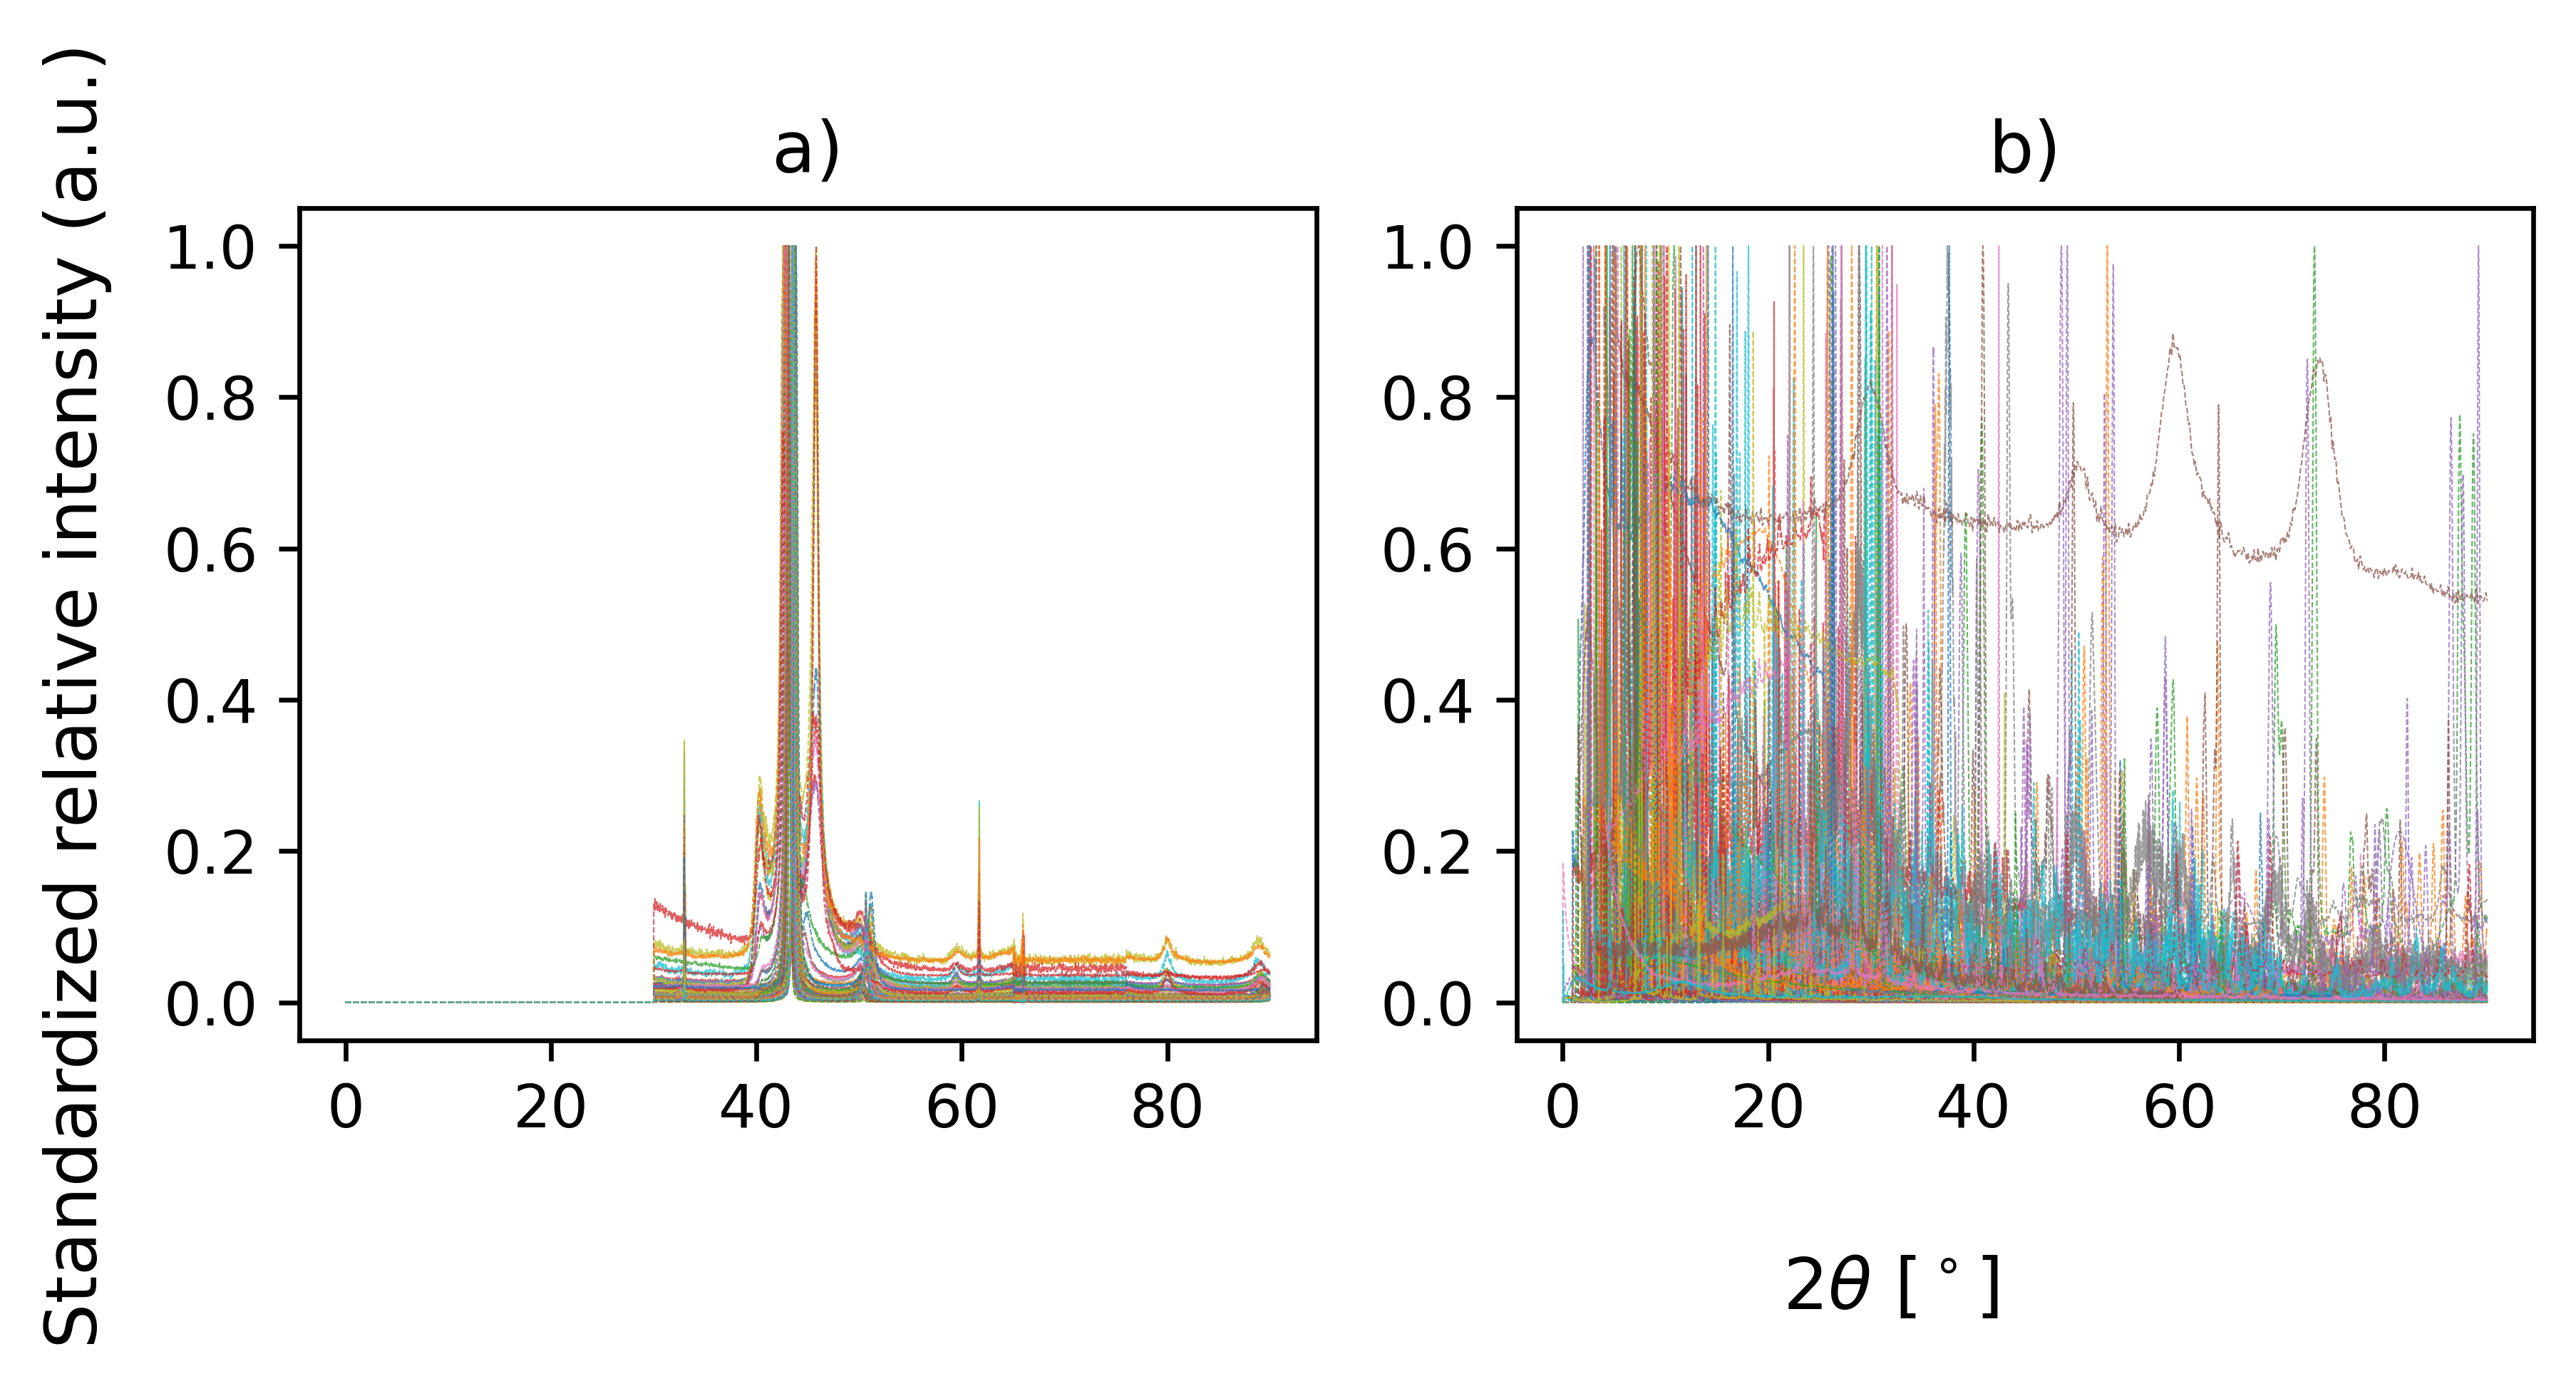

<IPython.core.display.Latex object>

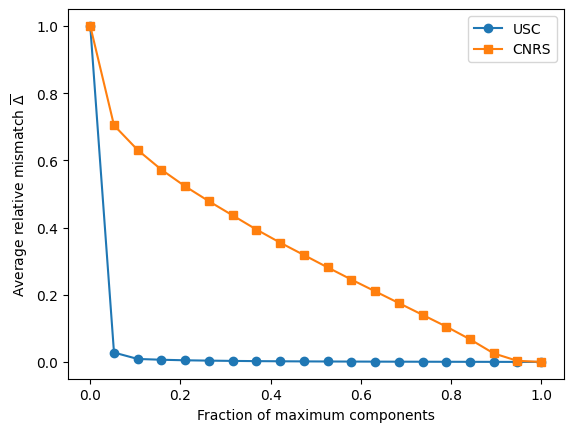

<IPython.core.display.Latex object>

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


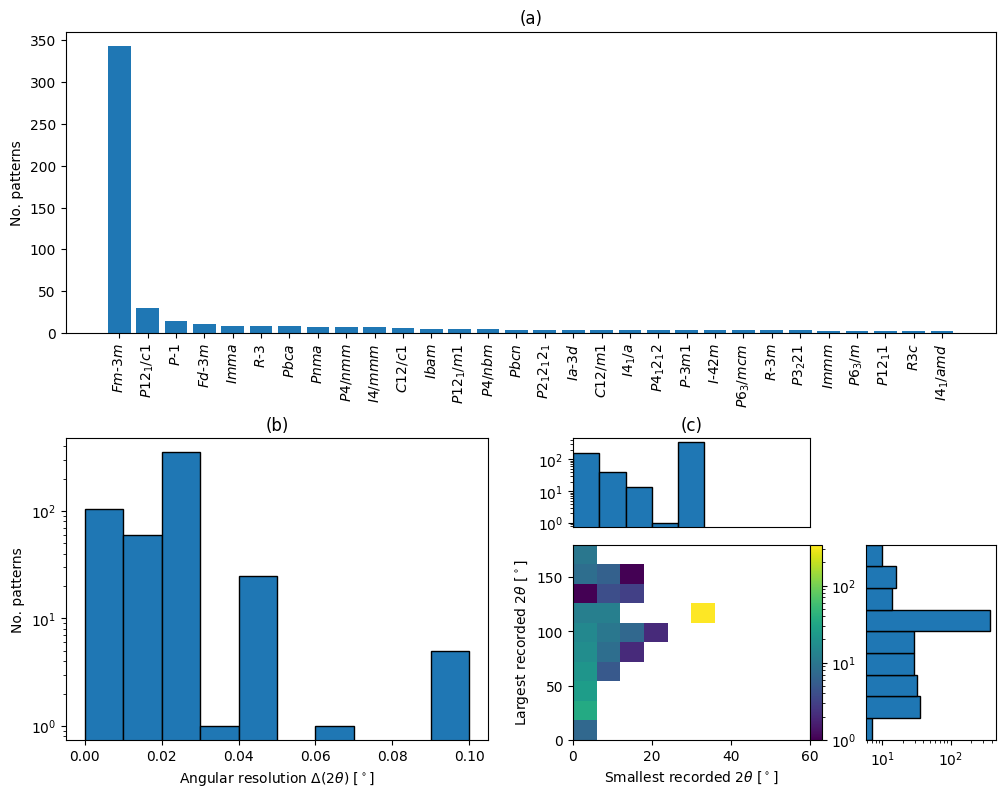

<IPython.core.display.Latex object>

+------+-------+-----------+---------------+---------------+
|      |   spg |   lattice |   atom_coords |   composition |
|------+-------+-----------+---------------+---------------|
| USC  |     1 |  0.899408 |      0        |      1        |
| CNRS |     1 |  1        |      0.828571 |      0.828571 |
+------+-------+-----------+---------------+---------------+


<IPython.core.display.Latex object>

Total number of patterns = 548
Number of labeled patterns = 548


In [50]:
analyser = DatabaseAnalyser(databases=opxrd_databases, output_dirpath='/tmp/opxrd_analysis')
analyser.run_all()